# Rede Neural Recorrente simples para classificar dígitos MNIST

Este experimento ilustra o uso de uma rede neural recorrente na tarefa de classificação
de dígitos manuscritos do dataset MNIST.

A imagem é estruturada em 28 sequências de 28 pixels cada. Cada elemento da sequência é
formado por uma linha da imagem. Cada linha da imagem contém 28 atributos (pixels).

<img src='../figures/RNN_MNIST.png', width= 700></img>

**Obs:** Este experimento foi inspirado no artigo:
"A Simple Way to Initialize Recurrent Networks of Rectified Linear Units"
by Quoc V. Le, Navdeep Jaitly, Geoffrey E. Hinton
arxiv:1504.00941v2 [cs.NE] 7 Apr 2015
http://arxiv.org/pdf/1504.00941v2.pdf

A principal modificação é a formatação da imagem em 28 sequências de 28 pixels.

## Importação

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from   torch.autograd import Variable

import torchvision

import lib.pytorch_trainer as ptt
use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: False


## Leitura do dataset

In [2]:
dataset_dir = '/data/datasets/MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')
x_test,  y_test  = torch.load(dataset_dir + 'processed/test.pt')

x_train = x_train.float()
x_test  = x_test.float()

x_train = x_train / 255.
x_test  = x_test  / 255.

## Pouquíssimas amostras - depurando apenas

In [3]:
if True:
    n_samples_train = 1000
    n_samples_test  = 500

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]
    x_test  = x_test[:n_samples_test]
    y_test  = y_test[:n_samples_test]

In [4]:
x_train.shape

torch.Size([1000, 28, 28])

## SimpleRNN com 100 neurônios

In [5]:
class Model_LSTM(nn.Module):
    def __init__(self, hidden_size):
        super(Model_LSTM, self).__init__()
        #self.rnn = nn.RNN(28, hidden_size, 1, batch_first=True, nonlinearity='relu', dropout=0.05) # 28 atributos, 100 neurônios, 1 camada  
        self.rnn = nn.LSTM(28, hidden_size, 1, batch_first=True, dropout=0.05) # 28 atributos, 100 neurônios, 1 camada  
        self.out = nn.Linear(hidden_size, 10)

    def forward(self, xin):
        _,(x,_) = self.rnn(xin)
        x  = self.out(x)
        return torch.squeeze(x,dim=0)
    
class Model_RNN(nn.Module):
    def __init__(self, hidden_size):
        super(Model_RNN, self).__init__()
        self.rnn = nn.RNN(28, hidden_size, 1, batch_first=True, nonlinearity='relu', dropout=0.05) # 28 atributos, 100 neurônios, 1 camada  
        self.out = nn.Linear(hidden_size, 10)

    def forward(self, xin):
        _,x = self.rnn(xin)
        x  = self.out(x)
        return torch.squeeze(x,dim=0)
    

model_rnn = Model_RNN(100)
#model_rnn = Model_LSTM(100)
if use_gpu:
    model_rnn = model_rnn.cuda()
model_rnn

Model_RNN (
  (rnn): RNN(28, 100, batch_first=True, dropout=0.05)
  (out): Linear (100 -> 10)
)

## Predict com uma amostra

In [7]:
xin = x_train[0:1]
xin = torch.zeros((1,28,28))
print('xin.shape:',xin.shape)
xv_in = Variable(xin)
ypred = model_rnn(xv_in)
print(torch.squeeze(ypred[:,:10]))

xin.shape: torch.Size([1, 28, 28])
Variable containing:
-0.0294
 0.1265
-0.0573
 0.1063
 0.0390
 0.0837
 0.0423
 0.0519
 0.0397
 0.0323
[torch.FloatTensor of size 10]



In [8]:
chkpt_cb = ptt.ModelCheckpoint('../../models/SimpleRNN_MNIST_t', reset=False, verbose=1)

trainer = ptt.DeepNetTrainer(model_rnn,
                        criterion = nn.CrossEntropyLoss(),
                        optimizer = torch.optim.Adam(model_rnn.parameters(),lr=1e-3),
                        callbacks = [chkpt_cb, ptt.AccuracyMetric(),ptt.PrintCallback()]
                        )

In [9]:
trainer.fit(20, x_train, y_train, valid_data=(x_test, y_test),batch_size=32)

Start training for 20 epochs
  1:   0.8s   T: 2.28785 0.13500   V: 2.26854 0.11000 best
  2:   0.7s   T: 2.14923 0.21900   V: 1.99881 0.30800 best
  3:   0.7s   T: 1.61806 0.43900   V: 1.60264 0.50400 best
  4:   0.7s   T: 1.35067 0.52400   V: 1.49860 0.53000 best
  5:   0.7s   T: 1.26618 0.56400   V: 1.44860 0.53400 best
  6:   0.7s   T: 1.20748 0.57100   V: 1.48562 0.48400 
  7:   0.7s   T: 1.19117 0.58300   V: 1.32602 0.54800 best
  8:   0.7s   T: 1.08198 0.62700   V: 1.34119 0.52400 
  9:   0.7s   T: 1.10301 0.61000   V: 1.23616 0.57400 best
 10:   0.7s   T: 1.07534 0.59900   V: 1.27465 0.57400 
 11:   0.7s   T: 1.03049 0.63100   V: 1.33033 0.53800 
 12:   0.7s   T: 1.00338 0.64700   V: 1.23322 0.58800 best
 13:   0.7s   T: 1.06497 0.61200   V: 1.22904 0.53600 best
 14:   0.7s   T: 0.97021 0.64600   V: 1.27806 0.55200 
 15:   0.7s   T: 0.95536 0.66500   V: 1.19279 0.60000 best
 16:   0.7s   T: 0.93714 0.65400   V: 1.26531 0.55800 
 17:   0.7s   T: 0.84151 0.69200   V: 1.24803 0.596

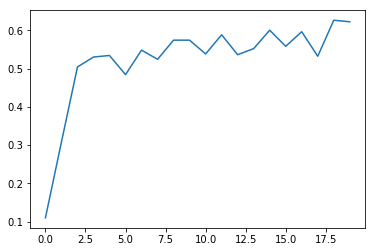

In [10]:
plt.plot(trainer.metrics['valid']['acc'])